In [1]:
# import required libraries
import os
from loader_util.nn.conv import ShallowNetTorch

# import pytorch imports
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# import numpy-pandas imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
device = torch.device("cpu")

In [2]:
# construct path to ImageFolder
pyth_dir = r"C:\Users\mhasa\Google Drive\Tutorial Corner\PYTH"
image_folder = os.path.join(pyth_dir,
                            'DeepLearning',
                            'DeepLearning-DL4CV',
                            'Edition3',
                            'SB_Code',
                            'datasets',
                            'animals')

In [4]:
# class CustomNormalize(object):
#     """
#     Divide the image pixel values by 255 to normalise them between [0-1]
#     """
#     def __call__(self, image:torch.Tensor):
#         # call function acts on a single test_sample
#         normlaised_tensor_image = image / 255.0
#         return normlaised_tensor_image
#         

In [3]:
# initialise image properties and batch size
batch_size = 32
image_height = 32
image_width = 32
image_channels = 3

# construct transformation
transform = transforms.Compose([
    transforms.Resize(size=(image_height,image_width)), # returns PIL Image
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    #CustomNormalize(),

])

# create and load the dataset
data = datasets.ImageFolder(image_folder, transform=transform) 
data_len = len(data)
data_indices = list(range(data_len))

# split data to train and test sets
test_data_percentage = 10
test_data_len = int(np.floor(data_len * test_data_percentage / 100))
test_idx, train_idx = data_indices[:test_data_len], \
                      data_indices[test_data_len:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

trainLoader = DataLoader(dataset=data,
                         batch_size=batch_size,
                         sampler=train_sampler)
validLoader = DataLoader(dataset=data,
                         batch_size=batch_size,
                         sampler=test_sampler)

In [4]:
# initialise the CNN model
model = ShallowNetTorch(width=image_width, 
                        height=image_height, 
                        depth=image_channels, 
                        classes=3)
model.to(device)

ShallowNetTorch(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): ReLU()
  (fc1): Linear(in_features=32768, out_features=3, bias=True)
)

In [5]:
# Train the model
epochs = 100
epoch_train_losses = []
epoch_train_accus = []
epoch_valid_losses = []
epoch_valid_accus = []

# define the loss
criterion = nn.CrossEntropyLoss()

# create the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# loop over the epochs
for epoch in range (1, epochs + 1):
    
    # keep track of all losses
    running_train_loss = 0
    running_valid_loss = 0
    
    running_train_acc = 0
    running_valid_acc = 0
    
    train_batch_no = 0
    valid_batch_no = 0
    
    # TRAIN
    model.train()
    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        train_batch_no += 1
        
        # Training pass
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        
        # exponentiate the logits
        exp_logits = torch.exp(logits)
        
        # pass thru softmax to calculate probs
        probs = exp_logits / (torch.sum(exp_logits, dim=1).view(exp_logits.shape[0],-1))
        
        # get top class and to class prob
        top_p, top_class = probs.topk(1, dim=1)
        
        # reshape labels into column vector
        labels = labels.view(labels.shape[0], -1)
    
        # find which labels are correctly classified
        acc_boolean = top_class == labels
       
        # finally calculate accuracy
        running_train_acc += np.sum(acc_boolean.cpu().numpy()) / len(acc_boolean)
        
        # make gradient descent step
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    else:
        epoch_train_loss = running_train_loss / train_batch_no
        epoch_train_losses.append(epoch_train_loss)
        epoch_train_accu = running_train_acc / train_batch_no
        epoch_train_accus.append(epoch_train_accu)
        print(f"Epoch: {epoch}")
        print(f'{train_batch_no} train batches completed')
        
        
    
    # VALIDATE
    model.eval()
    with torch.no_grad():
        for valid_images, valid_labels in validLoader:
            valid_images, valid_labels = valid_images.to(device), valid_labels.to\
                (device)
            valid_batch_no += 1
            
            # Validation pass
            valid_logits = model(valid_images)
            valid_loss = criterion(valid_logits, valid_labels)
            
            # exponentiate the logits
            valid_exp_logits = torch.exp(valid_logits)
            
            # pass thru softmax to calculate probs
            valid_probs = valid_exp_logits / (torch.sum(valid_exp_logits, dim=1)
                                              .view(valid_exp_logits.shape[0],-1))
            
            # get top class and to class prob
            valid_top_p, valid_top_class = valid_probs.topk(1, dim=1)
            
            # reshape labels into column vector
            valid_labels = valid_labels.view(valid_labels.shape[0], -1)
        
            # find which labels are correctly classified
            valid_acc_boolean = valid_top_class == valid_labels
           
            # finally calculate accuracy
            running_valid_acc += np.sum(valid_acc_boolean.cpu().numpy()) / len\
                (valid_acc_boolean)
    
            running_valid_loss += valid_loss.item()
        else:
            # dividing because running loss is the sum loss of all batches 
            epoch_valid_loss = running_valid_loss / valid_batch_no
            epoch_valid_accu = running_valid_acc / valid_batch_no
            epoch_valid_losses.append(epoch_valid_loss)
            epoch_valid_accus.append(epoch_valid_accu)
            print ( f"Training loss: {epoch_train_loss} " )
            print(f'Train accu: {epoch_train_accu}')
            print(f'{valid_batch_no} test batches completed')
            print ( f"Validation loss: {epoch_valid_loss}")
            print(f'Validation accu: {epoch_valid_accu}')
            print("=" * 50)

Epoch: 1
85 train batches completed
Training loss: 0.8660676458302666 
Train accu: 0.5878676470588236
10 test batches completed
Validation loss: 1.0823148608207702
Validation accu: 0.4083333333333333
Epoch: 2
85 train batches completed
Training loss: 0.6385152473169214 
Train accu: 0.722671568627451
10 test batches completed
Validation loss: 1.328489112854004
Validation accu: 0.27708333333333335
Epoch: 3
85 train batches completed
Training loss: 0.5425931965603548 
Train accu: 0.7770833333333332
10 test batches completed
Validation loss: 0.873308390378952
Validation accu: 0.5520833333333333
Epoch: 4
85 train batches completed
Training loss: 0.4697759077829473 
Train accu: 0.8098039215686273
10 test batches completed
Validation loss: 1.00733482837677
Validation accu: 0.471875
Epoch: 5
85 train batches completed
Training loss: 0.42012864070780137 
Train accu: 0.8278186274509803
10 test batches completed
Validation loss: 1.0087392389774323
Validation accu: 0.5114583333333333
Epoch: 6
85 t

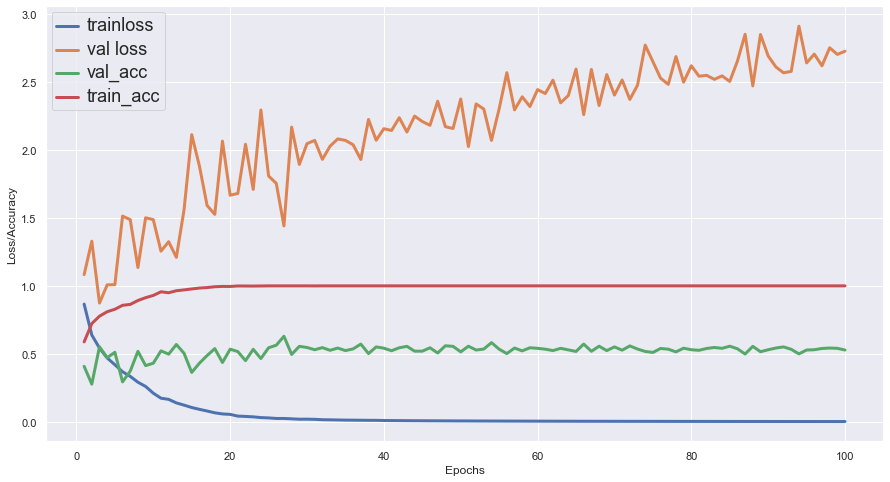

In [7]:
# evaluate the network
# plot the performance
import pandas as pd
epochs = range(1, 101)
plot_df = pd.DataFrame(data=np.c_[epochs, epoch_train_losses, 
                                  epoch_valid_losses, epoch_train_accus, 
                                  epoch_valid_accus], 
                       columns=['epochs','train_loss', 'test_loss', 
                                'train_acc', 'valid_acc'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='train_loss', ax=ax, label='trainloss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='test_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='valid_acc', ax=ax, label='val_acc', 
             linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='train_acc', ax=ax, 
             label='train_acc', linewidth=3)
ax.set_ylabel('Loss/Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text